<a href="https://colab.research.google.com/github/JinGunseon/MachineLearning/blob/main/InterestRateExpectation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 머신러닝을 이용한 한국 금리 예측 프로젝트
## 1. 개요
이 프로젝트에서는 머신러닝을 활용하여 한국의 금리를 예측하고자 한다. 금리에 영향을 미치는 요소들을 고려하여, 그에 대한 데이터를 취합하고, 전처리 후, 모델에 학습시켜 한국 금리를 예측한다.

## 2. 선형회귀를 통한 한국 금리 예측
본격적으로 프로젝트를 시작하기에 앞서, 시간 변수와 금리의 관계를 나타내는 선형회귀 모델을 분석한다. 가장 간단한 파라미터와 예측값이기 때문이다.

In [ ]:
import torch
print("CUDA Available:",torch.cuda.is_available())

CUDA Available: True



```torch.cuda.is_available()``` 는 PyTorch에서 GPU(CUDA)를 사용할 수 있는지 확인하는 함수이다. 하지만 지금은 PyTorch 대신 Scikit-Learn을 활용한 분석을 먼저 시작한다. GPT 선생님이 Scikit-Learn을 이용한 이유는 다음과 같다.

📌 1. PyTorch를 사용하지 않은 이유

✅ 단순한 회귀 모델은 Scikit-Learn이 더 쉽고 빠름

- 금리 예측 코드에서는 기본적인 선형 회귀(Linear Regression) 모델을 사용했습니다.
- Scikit-Learn의 LinearRegression() 모델은 몇 줄의 코드만으로 학습과 예측이 가능하므로, PyTorch를 사용하는 것보다 훨씬 간단하고 빠르게 실행됩니다.

✅ 딥러닝이 필요하지 않음
- 금리 예측에서 먼저 기본적인 머신러닝 모델(선형 회귀, 랜덤 포레스트, XGBoost) 로 접근하는 것이 일반적입니다.
- PyTorch는 주로 딥러닝(신경망) 모델을 만들 때 사용되므로, 간단한 선형 회귀를 위해 굳이 사용할 필요가 없었습니다.

✅ 모델 비교 및 실험을 빠르게 하기 위함
- 금리 예측 프로젝트에서는 먼저 간단한 모델을 테스트하고, 이후에 고도화하는 것이 중요합니다.
- Scikit-Learn을 활용하면 선형 회귀 외에도 랜덤 포레스트, XGBoost 등 다양한 모델을 손쉽게 적용할 수 있습니다.


In [ ]:
# 일자별 한국은행 기준금리 데이터를 받아오기

import requests
import pandas as pd

# 한국은행 ECOS API 키
API_KEY=""

# 기준금리 데이터 요청 URL
url = f"https://ecos.bok.or.kr/api/StatisticSearch/{API_KEY}/json/en/1/100/722Y001/M/200001/202512"

# 데이터 요청 및 json 변환
response = requests.get(url)
data = response.json()

items = data['StatisticSearch']['row']
df = pd.DataFrame(items)[['TIME','DATA_VALUE']]
df.columns = ['Date', 'Interest Rate']
df['Date'] = pd.to_datetime(df['Date'], format='%Y%m');
df = df.sort_values('Date')

# 데이터 확인
print("한국은행 기준금리 데이터")
display(df)

한국은행 기준금리 데이터


,Date,Interest Rate
0,2000-01-01,4.75
1,2000-01-01,5
2,2000-01-01,3
3,2000-02-01,5
4,2000-02-01,5
...,...,...
95,2002-08-01,2.5
97,2002-09-01,5
98,2002-09-01,2.5
96,2002-09-01,4.25


RMSE:  1.1018320218344404


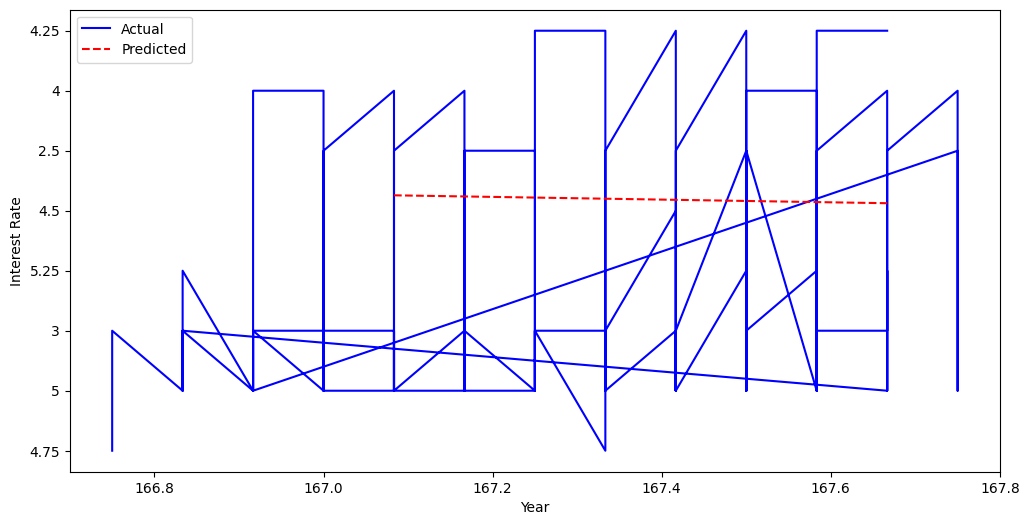

In [ ]:
# 데이터 전처리
# 선형회귀 모형을 이용한 분석

import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics  import mean_squared_error

# 데이터 전처리
df['Year'] = df['Date'].dt.year
df['Month'] = df['Date'].dt.month
df['Time'] = (df['Year']+df['Month'])/12 # 연도+월을 정규화

X = df[['Time']]
y = df['Interest Rate']

# 학습/테스트 데이터 분할
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

# 선형 회귀 모델 학습
model = LinearRegression()
model.fit(X_train, y_train)

# 테스트 데이터로 예측
y_pred = model.predict(X_test)

# 모델 평가
rmse = np.sqrt((mean_squared_error(y_test, y_pred)))
print("RMSE: ",rmse)

# 시각화
plt.figure(figsize=(12,6))
plt.plot(df['Time'], df['Interest Rate'], label='Actual', color = 'blue')
plt.plot(X_test, y_pred, label='Predicted', linestyle='dashed', color = 'red')

plt.xlabel('Year')
plt.ylabel('Interest Rate')
plt.legend()
plt.show()

## 3. 개선된 선형 회귀모델 구축

📌 1. 지난 분석의 문제점

GPT 선생님이 처음 제시한 분석은 단순히 연도와 월을 정규화한 한 것(시간변수)과 금리의 관계를 나타낸 것이었다. 이것으로 금리를 예측할 수 있을까?? 지난 분석은 다음과 같은 문제점들이 있다.

🔍 단순히 연도+월을 정규화한 경우의 한계

1️⃣ 시간 흐름만 반영, 경제적 요인은 반영되지 않음
- 금리는 단순한 시간 흐름이 아니라 경제 지표(GDP 성장률, 물가 상승률 등)의 영향을 받음
- 단순히 시간(X축)과 금리(Y축)만을 고려하면 외부 경제적 요인을 설명하지 못함

2️⃣ 비선형적 변화 반영 부족
- 금리는 선형적으로 증가하거나 감소하지 않고, 중앙은행의 정책에 따라 급격히 변할 수 있음
- 단순 선형 회귀는 이러한 변화를 잘 포착하지 못할 가능성이 큼

3️⃣ 미래 예측력 부족
- 과거 데이터를 기반으로 학습한 후 미래 금리를 예측하려면, 금리 변동에 영향을 주는 변수들을 함께 고려해야 함
- 단순한 Time 변수만으로는 예측력이 낮아질 가능성이 큼

📌 2. 유의미한 분석을 위해 추가해야 할 변수
이러한 문제점들을 해결하기 위해 다음과 같은 변수들을 추가한다.


📊 주요 변수들 (한국은행 ECOS API 활용 가능)

|변수|설명|
|---|---|
|GDP 성장률|	경제 성장률이 높으면 금리 상승 가능성↑|
|소비자물가지수(CPI)|	물가가 오르면 금리 상승 가능성↑|
|실업률|	실업률이 높으면 금리 인하 가능성↑|
|국채 금리(10년물, 2년물)|	장기 금리가 단기 금리보다 높으면 금리 상승 가능성↑|
|한미 기준금리 차이|	미국 기준금리와의 차이가 금리 결정에 영향|

📌 3. 개선된 선형 회귀 모델 구축

✅ ① 데이터 수집 및 전처리
1. ECOS API를 활용하여 GDP, CPI, 실업률, 국채 금리 등의 데이터를 가져옴
2. 모든 데이터를 날짜 기준으로 병합
3. 결측값 처리 및 정규화(Scaling)

In [16]:
import requests
import pandas as pd
from sklearn.preprocessing import StandardScaler

API_KEY = "D0B6SPV5M22B27X465O3"

# 금리 데이터 가져오기(분기별)
rate_url = f"https://ecos.bok.or.kr/api/StatisticSearch/{API_KEY}/json/en/1/100/722Y001/Q/2000Q1/2024Q4/0101000"
rate_data = requests.get(rate_url).json()
rate_df = pd.DataFrame(rate_data['StatisticSearch']['row'])[['TIME', 'DATA_VALUE']]
rate_df.columns = ['Quarter', 'Interest Rate']

# GDP 성장률 데이터 가져오기(연간 데이터)
gdp_url = f"https://ecos.bok.or.kr/api/StatisticSearch/{API_KEY}/json/en/1/100/251Y003/A/2000/2024/S/NS1D"
gdp_data = requests.get(gdp_url).json()
gdp_df = pd.DataFrame(gdp_data['StatisticSearch']['row'])[['TIME', 'DATA_VALUE']]
gdp_df.columns = ['Year', 'GDP Growth']

# 🚀 [중요] 첫 연도의 NaN 값 채우기 (Deprecated 경고 해결)
gdp_df['GDP Growth'] = gdp_df['GDP Growth'].bfill()  # `fillna(method='bfill')` 대신 사용. 첫 연도 값 채움

# 🛠 GDP 성장률을 연간 → 분기별 성장률로 변환 (연간 성장률을 4등분)
gdp_df['Year'] = gdp_df['Year'].astype(int)  # 연도 정수 변환
gdp_df['GDP Growth'] = gdp_df['GDP Growth'].astype(float)  # 숫자로 변환

# 📌 분기별 성장률 데이터 생성
quarterly_gdp = []
for _, row in gdp_df.iterrows():
    year = int(row['Year'])
    annual_growth = row['GDP Growth']
    quarterly_growth = annual_growth / 4  # 연간 성장률을 4등분

    # 각 연도의 4개 분기를 생성
    for q in range(1, 5):
        quarterly_gdp.append({'Quarter': f"{year}Q{q}", 'GDP Growth': quarterly_growth})

# 분기별 GDP 성장률 데이터프레임 생성
gdp_quarterly_df = pd.DataFrame(quarterly_gdp)


# 실업률 데이터 가져오기(분기별)
unemployment_url = f"https://ecos.bok.or.kr/api/StatisticSearch/{API_KEY}/json/en/1/100/901Y027/Q/2000Q1/2024Q4/I61BC/I28B"
unemployment_data = requests.get(unemployment_url).json()
unemployment_df = pd.DataFrame(unemployment_data['StatisticSearch']['row'])[['TIME', 'DATA_VALUE']]
unemployment_df.columns = ['Quarter', 'Unemployment Rate']

# 데이터 병합
df = rate_df.merge(gdp_quarterly_df, on='Quarter', how='left')
df = df.merge(unemployment_df, on='Quarter', how='left')

# 🛠 NaN 확인
print("🔍 NaN 개수 확인 (병합 후):")
print(df.isna().sum())  # 어느 변수에 NaN이 있는지 확인
display(gdp_quarterly_df)
display(df)

# 🛠 NaN 제거
df.dropna(inplace=True)  # NaN 포함된 행 삭제

# 숫자로 변환
df[['Interest Rate', 'GDP Growth', 'Unemployment Rate']] = df[['Interest Rate', 'GDP Growth', 'Unemployment Rate']].astype(float)

# 날짜 변수를 숫자로 변환
df['Year'] = df['Quarter'].str[:4].astype(int)  # 연도 추출
df['Quarter_Num'] = df['Quarter'].str[-1].astype(int)  # 분기 번호 추출
df['Time'] = df['Year'] + (df['Quarter_Num'] - 1) / 4  # 연도+분기 정규화

# 특성(Features) 설정
features = ['Time', 'GDP Growth', 'Unemployment Rate']
scaler = StandardScaler()
df[features] = scaler.fit_transform(df[features])


# 데이터 확인
print("금리 예측 데이터")
display(df)


🔍 NaN 개수 확인 (병합 후):
Quarter              0
Interest Rate        0
GDP Growth           4
Unemployment Rate    0
dtype: int64


,Quarter,GDP Growth
0,2000Q1,1.175
1,2000Q2,1.175
2,2000Q3,1.175
3,2000Q4,1.175
4,2001Q1,1.175
...,...,...
91,2022Q4,0.675
92,2023Q1,0.350
93,2023Q2,0.350
94,2023Q3,0.350


,Quarter,Interest Rate,GDP Growth,Unemployment Rate
0,2000Q1,5,1.175,4.8
1,2000Q2,5,1.175,4.3
2,2000Q3,5,1.175,4.3
3,2000Q4,5.25,1.175,4.2
4,2001Q1,5,1.175,4.5
...,...,...,...,...
95,2023Q4,3.5,0.350,2.8
96,2024Q1,3.5,NaN,2.8
97,2024Q2,3.5,NaN,2.8
98,2024Q3,3.5,NaN,2.5


금리 예측 데이터


,Quarter,Interest Rate,GDP Growth,Unemployment Rate,Year,Quarter_Num,Time
0,2000Q1,5.00,0.585789,3.147836,2000,1,-1.714102
1,2000Q2,5.00,0.585789,1.906290,2000,2,-1.678015
2,2000Q3,5.00,0.585789,1.906290,2000,3,-1.641929
3,2000Q4,5.25,0.585789,1.657981,2000,4,-1.605843
4,2001Q1,5.00,0.585789,2.402909,2001,1,-1.569756
...,...,...,...,...,...,...,...
91,2022Q4,3.25,-0.516873,-1.818347,2022,4,1.569756
92,2023Q1,3.50,-1.233603,-2.066657,2023,1,1.605843
93,2023Q2,3.50,-1.233603,-2.314966,2023,2,1.641929
94,2023Q3,3.50,-1.233603,-2.066657,2023,3,1.678015


전처리에서 엄청 고생했는데 커밋 마감시간이 다가오므로 내일 정리해야지...


In [18]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

# 입력(X)과 출력(y) 설정
X = df[['Time', 'GDP Growth', 'Unemployment Rate']]
y = df['Interest Rate']

# 학습/테스트 데이터 분할
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

# 선형 회귀 모델 학습
model = LinearRegression()
model.fit(X_train, y_train)

# 예측
y_pred = model.predict(X_test)

# 성능 평가
rmse = mean_squared_error(y_test, y_pred)**0.5
print("RMSE:", rmse)


RMSE: 1.3445111343923306


RMSE 값이 1.34...로 나왔다. 이는 좋은 값은 아니다. 개선을 위한 방법은 내일 더...

시각화

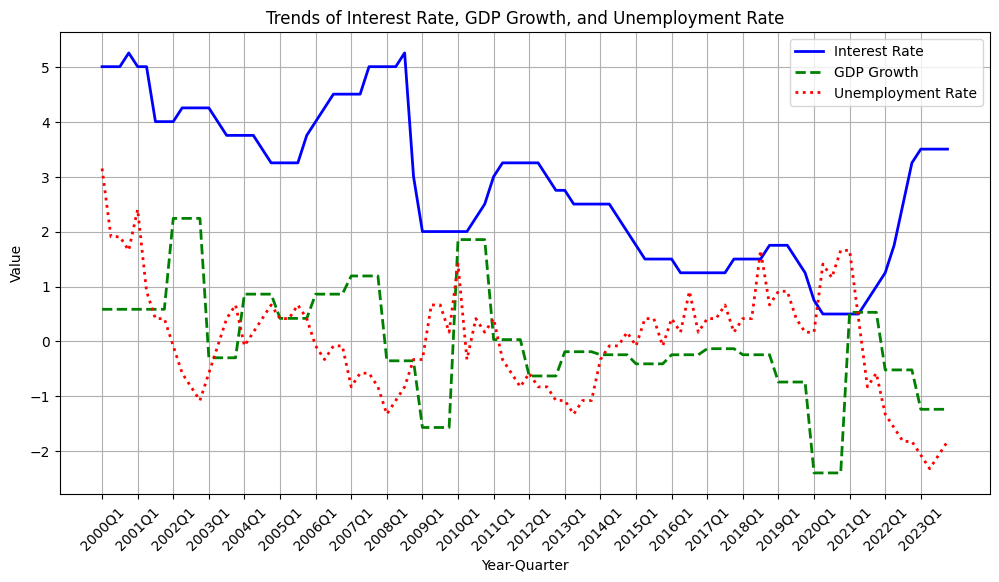

In [21]:
import matplotlib.pyplot as plt

# 📌 X축 레이블 생성 (2000Q1, 2000Q2, ...)
df['Year-Quarter'] = df['Quarter']  # 기존 'Quarter' 컬럼을 X축 레이블로 사용

# 📌 그래프 크기 설정
plt.figure(figsize=(12, 6))

# 📌 금리 그래프
plt.plot(df['Year-Quarter'], df['Interest Rate'], label='Interest Rate', color='blue', linewidth=2)

# 📌 GDP 성장률 그래프
plt.plot(df['Year-Quarter'], df['GDP Growth'], label='GDP Growth', color='green', linestyle='dashed', linewidth=2)

# 📌 실업률 그래프
plt.plot(df['Year-Quarter'], df['Unemployment Rate'], label='Unemployment Rate', color='red', linestyle='dotted', linewidth=2)

# 📌 X축 레이블 조정 (가독성을 위해 일부 레이블만 표시)
plt.xticks(df['Year-Quarter'][::4], rotation=45)  # 4분기(1년) 단위로 간격 조정하여 표시

# 📌 그래프 설정
plt.xlabel("Year-Quarter")  # X축 이름을 더 직관적으로 변경
plt.ylabel("Value")
plt.title("Trends of Interest Rate, GDP Growth, and Unemployment Rate")
plt.legend()
plt.grid(True)

# 📌 그래프 표시
plt.show()
